# 1D testing STDP model network

http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity

STDP can be seen as a spike-based formulation of a Hebbian learning rule. 

In [1]:
# fileName

fileName = 'eg_1D_testing-STDP-model-network'

In [2]:
# libs

import pyNN.nest as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt


/home/alberto-int/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'pynestkernel' does not match runtime version 3.7
  return f(*args, **kwds)


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/alberto-int/anaconda3/lib/python3.7/site-packages/PyNN-0.9.5-py3.7.egg/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 # [ms+]



/usr/lib/python3.5/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


## make the network

In [4]:
# define make_pop

pops = {}

pops['pre'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_cond_exp(),
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        label='network'
                        )
                        
pops['post'] = sim.Population(
                        1, # one cell in each cell model
                        sim.IF_cond_exp(),
                        structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                        label='network'
                        )

pops['pre'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])
pops['post'].record(['spikes', 'v', 'gsyn_exc', 'gsyn_inh'])



pops.keys()

NEST does not allow setting an initial value for g_ex
NEST does not allow setting an initial value for g_in
NEST does not allow setting an initial value for g_ex
NEST does not allow setting an initial value for g_in


dict_keys(['pre', 'post'])

## make the thalamic input stimulus

In [5]:

pops['thalamus-pre'] = sim.Population(1, 
                            sim.SpikeSourceArray(spike_times=[0, 10, 30, 40, 50, 60, 70, 80, 90, 110, 120]),
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            )    

pops['thalamus-post'] = sim.Population(1, 
                             sim.SpikeSourceArray(spike_times=[32, 42, 52, 62, 72, 82, 92]),
                             structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0))

pops['thalamus-post'].record('spikes')
pops['thalamus-pre'].record('spikes')


pops.keys()

dict_keys(['pre', 'post', 'thalamus-pre', 'thalamus-post'])

## make learning rule between pre and post syn cells

In [6]:
timing = sim.SpikePairRule(tau_plus=10.0, 
                           tau_minus=1.0, 
                           A_plus=0.5, 
                           A_minus=0.5)

weight = sim.AdditiveWeightDependence(w_max=5.0, w_min=0.0) # range of learnig


projs = {}
projs['pre', 'post'] = sim.Projection(pops['pre'], pops['post'], 
                                      sim.OneToOneConnector(), 
                                      sim.STDPMechanism(
                                          timing_dependence=timing, 
                                          weight_dependence=weight, 
                                          weight=0.0, 
                                          delay=5.0))

projs.keys()

Several STDP models are available for these connections:
stdp_synapse
By default, stdp_synapse is used


dict_keys([('pre', 'post')])

## make the thalamic - pops projections

In [7]:

projs['thalamus-pre', 'pre'] = sim.Projection(
                                    pops['thalamus-pre'],
                                    pops['pre'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=None),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )


projs['thalamus-post', 'post'] = sim.Projection(
                                    pops['thalamus-post'],
                                    pops['post'],
                                    sim.OneToOneConnector(),
                                    synapse_type=sim.StaticSynapse(weight=5),#, delay=1.0),
                                    receptor_type = 'excitatory',
                                    space = space.Space(axes = 'x'),
                                    label=None,
                                )



projs.keys()

dict_keys([('pre', 'post'), ('thalamus-pre', 'pre'), ('thalamus-post', 'post')])

## run the simulation

In [8]:
sim.run(simtime) 

250.0

## save results

In [9]:
# save the results

outputs = {}

for syn in ['pre', 'post', 'thalamus-pre', 'thalamus-post']:
    outputs[syn] = pops[syn].get_data()
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[syn].write_data(fileName + '_' + str(recording) + '.pkl')


## recover results

In [10]:
# make the recover results function

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): 
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results


In [11]:
# recover results

results = recover_results(outputs)
results.keys()

gsyn_exc
v
gsyn_inh
gsyn_exc
v
gsyn_inh


dict_keys([('pre', 'gsyn_exc'), ('pre', 'v'), ('pre', 'gsyn_inh'), ('pre', 'spikes'), ('post', 'gsyn_exc'), ('post', 'v'), ('post', 'gsyn_inh'), ('post', 'spikes'), ('thalamus-pre', 'spikes'), ('thalamus-post', 'spikes')])

In [12]:
results.keys()

dict_keys([('pre', 'gsyn_exc'), ('pre', 'v'), ('pre', 'gsyn_inh'), ('pre', 'spikes'), ('post', 'gsyn_exc'), ('post', 'v'), ('post', 'gsyn_inh'), ('post', 'spikes'), ('thalamus-pre', 'spikes'), ('thalamus-post', 'spikes')])

## check the spikes

Text(27.125, 0.5, 'cells ID')

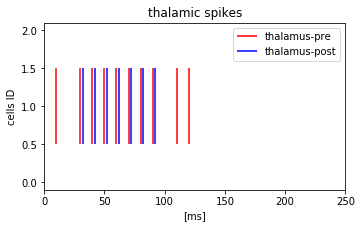

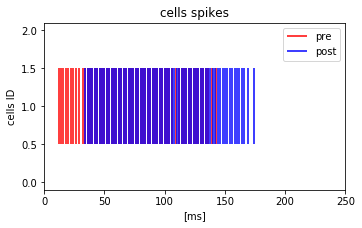

In [19]:
fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes

axes_list[0].eventplot(results['thalamus-pre', 'spikes'], label='thalamus-pre', color='r')
axes_list[0].eventplot(results['thalamus-post', 'spikes'], label='thalamus-post', color='b')
axes_list[0].set_title('thalamic spikes')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')
axes_list[0].set_xlim(0,simtime)
#axes_list[0].set_ylim(0,2)
axes_list[0].legend()

fig, axes = plt.subplots(1,1)
fig.tight_layout(pad=5)
axes_list = fig.axes
axes_list[0].eventplot(results['pre', 'spikes'], label='pre', color='r')
axes_list[0].eventplot(results['post', 'spikes'], label='post', color='b')
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_title('cells spikes')
axes_list[0].set_xlim(0,simtime)
axes_list[0].legend()
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells ID')



## check the voltage signature

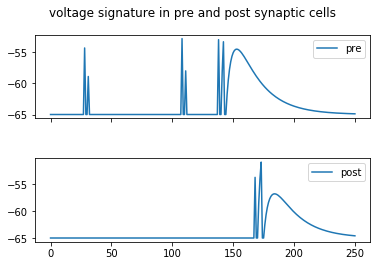

In [20]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('voltage signature in pre and post synaptic cells')

axes_list = fig.axes
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'v'], label=str(syn))
    axes_list[idx].legend()

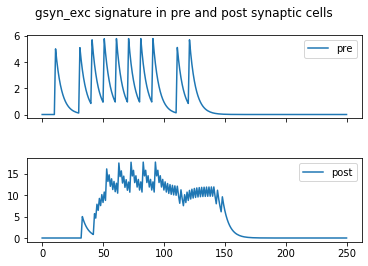

In [21]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)#, figsize=(11,7))
fig.tight_layout(pad=3)
fig.suptitle('gsyn_exc signature in pre and post synaptic cells')

axes_list = fig.axes
idx = 0
for idx, syn in enumerate(['pre', 'post']):
    axes_list[idx].plot(results[syn, 'gsyn_exc'], label=str(syn))
    axes_list[idx].legend()

## check the STDP between pre and post cells

In [22]:
projs.keys()

dict_keys([('pre', 'post'), ('thalamus-pre', 'pre'), ('thalamus-post', 'post')])

In [23]:
#projs['pre', 'post'].get(['source', 'target', 'weight', 'delay'], "list")
projs['pre', 'post'].getWeights()

# the weight between pre and post neuron was set to zero before the learning, now it's ..

[4.608705893125835]

## end the simulations

In [24]:
sim.end()

# task1: on thalamus input spike times
- test different interspike timing <br>
  e.g., <br>
    a=np.arange(0,100,10) for the thalamus-pre <br>
    a+15 for the thalamus post <br>
    
- test only one spike source eliciting the pre synaptic cell<br>
  remember to set the starting weight > 0, otherwise the post synaptic doesn't learn

# task2: on STDP mechanism
- try to change the parameter inside the SpikePairRule

